### Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow-addons --user
!pip install matplotlib -U --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# basics
import numpy as np
import PIL.Image as Image #
import os #
import pathlib #
import matplotlib.pylab as plt
import random
import cv2
import tensorflow as tf
from tensorflow import keras
# datageneraton
from keras.preprocessing.image import ImageDataGenerator
# for new top layers
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
# hypeparameters
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow_addons.metrics import F1Score
# models
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169

In [4]:
print(tf.__version__)

2.8.0


### Set Up

In [5]:
# Settings parameters
data_dir = "/content/drive/MyDrive/Colab Notebooks/train_test_split_ck"
assert os.path.isdir(data_dir), "Not Found"
(height, width, channels) = (80, 48, 3) 
batch_size = 16 

In [6]:
# function to update the image dimensions, according to the model input restrictions
def dubble_image_size(img):
    size = (48, 80)
    return cv2.resize(img, size) # dubble the image size

In [7]:
# create a the training data generator (with augmentation methods)
train_datagen = ImageDataGenerator(# Augmentation_methods
                                   rotation_range=10, # rotate randomly for [0,10] degrees
                                   horizontal_flip=True, # flip horizontally
                                   vertical_flip=True, # flip vertically
                                   width_shift_range=0.05, # shift in width randomly for [0,5]%
                                   height_shift_range=0.05, # shift in height randomly for [0,5]%
                                   brightness_range=[0.3,0.9],
                                   shear_range=0.1, # shear randomly for [0,1]%
                                   zoom_range=0.2, # zoom randomly for [0,2]%
                                   # Normilize images
                                   rescale=1.0/255.0,
                                   # Resizing
                                   preprocessing_function=dubble_image_size
                                  )

# load and iterate training dataset
train_it = train_datagen.flow_from_directory(directory=data_dir + '/train',
                                             target_size=(height, width),
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             save_format='jpg'
                                            )

# create a the validation and test data generator
val_test_datagen = ImageDataGenerator(# Normilize images
                                      rescale=1.0/255.0,
                                      # Resizing
                                      preprocessing_function=dubble_image_size
                                     )

# load and iterate validation dataset
val_it = val_test_datagen.flow_from_directory(directory=data_dir + '/val',
                                              target_size=(height, width),
                                              class_mode='categorical',
                                              batch_size=batch_size,
                                              save_format='jpg'
                                             )

# load and iterate test dataset
test_it = val_test_datagen.flow_from_directory(directory=data_dir + '/test',
                                               target_size=(height, width),
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               save_format='jpg'
                                              )

Found 337 images belonging to 5 classes.
Found 167 images belonging to 5 classes.
Found 174 images belonging to 5 classes.


In [8]:
n_classes = train_it.num_classes
print(f'Number of Classes: {n_classes}')

Number of Classes: 5


### Calculate weights (strongly imbalanced data)

In [9]:
samples_dict = dict()
total_samples = 0
dataset_dir = os.path.join(data_dir, "train")

for anomaly in os.listdir(dataset_dir):
    anomaly_dir = os.path.join(dataset_dir,anomaly)
    anomaly_count = len(os.listdir(anomaly_dir))   
    samples_dict[anomaly] = anomaly_count
    total_samples += anomaly_count

In [10]:
class_weights = {}

for i in range(n_classes):
    w = total_samples / (n_classes * samples_dict[list(samples_dict.keys())[i]])
    class_weights[i] = w

In [11]:
class_weights

{0: 1.0059701492537314,
 1: 1.6047619047619048,
 2: 0.7659090909090909,
 3: 1.8216216216216217,
 4: 0.654368932038835}

### Train all models

In [12]:
warm_up_epochs = 15
max_epochs = 30
warm_up_lr = 0.005
fine_tune_lr = 0.0001

def lr_scheduler(epoch, lr):
    
    if epoch < warm_up_epochs:
        
        lr = warm_up_lr

        return lr
    
    else:
        start_epoch = warm_up_epochs
        end_epoch = max_epochs
        start_lr = fine_tune_lr
        end_lr = 0
        
        slope = (end_lr-start_lr)/(end_epoch-start_epoch)
        
        lr = start_lr + slope * (epoch - start_epoch)
        
        return lr
       
callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [13]:
models = {'NASNetMobile':NASNetMobile,
        'VGG16':VGG16,
        'VGG19':VGG19,
        'EfficientNetB0':EfficientNetB0,
        'EfficientNetB1':EfficientNetB1,
        'EfficientNetB2':EfficientNetB2,
        'EfficientNetB3':EfficientNetB3,
        'EfficientNetB4':EfficientNetB4,
        'EfficientNetB5':EfficientNetB5,
        'EfficientNetB6':EfficientNetB6,
        'EfficientNetB7':EfficientNetB7,
        'ResNet50V2':ResNet50V2,
        'ResNet101V2':ResNet101V2,
        'ResNet152V2':ResNet152V2,
        'MobileNetV2':MobileNetV2,
        #'InceptionV3':InceptionV3, # Need bigger images
        #'Xception':Xception, # Need bigger images
        'DenseNet121':DenseNet121,
        'DenseNet169':DenseNet169
         }

In [14]:
history_warm_up = {}
history_fine_tuning = {}
history_evaluation = {}

for idx, model_name in enumerate(models.keys()):
    
    print(f'{model_name} {"-"*100}')
    
    model_class = models[model_name] # call the model architexture
    # specify model parameters
    model = model_class(include_top=False, # do not include the first layer. This is necessary to change the input tensor size
                        weights='imagenet', # pretraind weights from imagnet
                        input_tensor=Input(shape=(height, width, channels)), # (height=80, width=48, channels=3)
                        pooling='avg' # pooling type after last convolution layer
                       )
    
    # freeze the model
    for layer in model.layers:
        layer.trainable = False
        
    # add new layers at-the end
    x = Flatten()(model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    prediction = Dense(n_classes, activation='softmax')(x)
    
    # define the new model
    model = Model(inputs=model.input, outputs=prediction)
    
    # compile
    model.compile(optimizer = Adam(),
                  loss = CategoricalCrossentropy(),
                  metrics = [F1Score(num_classes=n_classes, name='f1_score', average='macro'),
                             TopKCategoricalAccuracy(k=1, name='top_1_accuracy')]
                 )
    
    # let's warm up the new layers!
    print('Training (Warm_Up):')
    history_warm_up[model_name] = model.fit(train_it,
                                            epochs=warm_up_epochs,
                                            validation_data=(val_it),
                                            class_weight=class_weights,
                                            callbacks=[callback], # to scadule the learning rate
                                            workers=-1,
                                            use_multiprocessing=True
                                           )
    
    # un-freeze the model
    for layer in model.layers:
          layer.trainable = True
    
    # let's fine tune it!
    print('Training (Fine_tune):')
    history_fine_tuning[model_name] = model.fit(train_it,
                                                epochs=max_epochs, # end epoch (including the previous training epochs)
                                                initial_epoch=warm_up_epochs, # continue from previous epoch
                                                validation_data=(val_it),
                                                class_weight=class_weights,
                                                callbacks=[callback], # to scadule the learning rate
                                                workers=-1,
                                                use_multiprocessing=True
                                               )
    
    # Evaluation time!
    print('Evaluation:')
    history_evaluation[model_name] = model.evaluate(test_it,
                                                    workers=-1,
                                                    use_multiprocessing=True
                                                   )
    
    print()
    print() # NEXT!

NASNetMobile ----------------------------------------------------------------------------------------------------
Training (Warm_Up):
Epoch 1/15
22/22 [==============================] - 19s 260ms/step - loss: 3.6153 - f1_score: 0.2359 - top_1_accuracy: 0.3531 - val_loss: 1.5881 - val_f1_score: 0.2316 - val_top_1_accuracy: 0.4551 - lr: 0.0050
Epoch 2/15
22/22 [==============================] - 2s 82ms/step - loss: 1.5375 - f1_score: 0.3010 - top_1_accuracy: 0.4599 - val_loss: 1.2878 - val_f1_score: 0.2952 - val_top_1_accuracy: 0.4731 - lr: 0.0050
Epoch 3/15
22/22 [==============================] - 2s 84ms/step - loss: 1.5550 - f1_score: 0.3307 - top_1_accuracy: 0.4481 - val_loss: 1.2415 - val_f1_score: 0.3573 - val_top_1_accuracy: 0.5090 - lr: 0.0050
Epoch 4/15
22/22 [==============================] - 2s 82ms/step - loss: 1.4378 - f1_score: 0.3077 - top_1_accuracy: 0.4599 - val_loss: 1.2176 - val_f1_score: 0.3532 - val_top_1_accuracy: 0.5449 - lr: 0.0050
Epoch 5/15
22/22 [==============

In [15]:
# For the two models (InceptionV3, Xception) that need bigger images

In [16]:
nheight = 160
nwidth = 96

In [17]:
# function to update the image dimensions, according to the model input restrictions
def quadruple_image_size(img):
    size = (nwidth, nheight)
    return cv2.resize(img, size) # dubble the image size

In [18]:
# create a the training data generator (with augmentation methods)
train_datagen = ImageDataGenerator(# Augmentation_methods
                                   rotation_range=10, # rotate randomly for [0,10] degrees
                                   horizontal_flip=True, # flip horizontally
                                   vertical_flip=True, # flip vertically
                                   width_shift_range=0.05, # shift in width randomly for [0,5]%
                                   height_shift_range=0.05, # shift in height randomly for [0,5]%
                                   brightness_range=[0.3,0.9],
                                   shear_range=0.1, # shear randomly for [0,1]%
                                   zoom_range=0.2, # zoom randomly for [0,2]%
                                   # Normilize images
                                   rescale=1.0/255.0,
                                   # Resizing
                                   preprocessing_function=quadruple_image_size
                                  )

# load and iterate training dataset
train_it = train_datagen.flow_from_directory(directory=data_dir + '/train',
                                             target_size=(nheight, nwidth),
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             save_format='jpg'
                                            )

# create a the validation and test data generator
val_test_datagen = ImageDataGenerator(# Normilize images
                                      rescale=1.0/255.0,
                                      # Resizing
                                      preprocessing_function=quadruple_image_size
                                     )

# load and iterate validation dataset
val_it = val_test_datagen.flow_from_directory(directory=data_dir + '/val',
                                              target_size=(nheight, nwidth),
                                              class_mode='categorical',
                                              batch_size=batch_size,
                                              save_format='jpg'
                                             )

# load and iterate test dataset
test_it = val_test_datagen.flow_from_directory(directory=data_dir + '/test',
                                               target_size=(nheight, nwidth),
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               save_format='jpg'
                                              )

Found 337 images belonging to 5 classes.
Found 167 images belonging to 5 classes.
Found 174 images belonging to 5 classes.


In [19]:
models['InceptionV3'] = InceptionV3
models['Xception'] = Xception

In [20]:
for idx, model_name in enumerate(['InceptionV3','Xception']):
    
    print(f'{model_name} {"-"*100}')
    
    model_class = models[model_name] # call the model architexture
    # specify model parameters
    model = model_class(include_top=False, # do not include the first layer. This is necessary to change the input tensor size
                        weights='imagenet', # pretraind weights from imagnet
                        input_tensor=Input(shape=(nheight, nwidth, channels)), # (height=80, width=48, channels=3)
                        pooling='avg' # pooling type after last convolution layer
                       )
    
    # freeze the model
    for layer in model.layers:
        layer.trainable = False
        
    # add new layers at-the end
    x = Flatten()(model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    prediction = Dense(n_classes, activation='softmax')(x)
    
    # define the new model
    model = Model(inputs=model.input, outputs=prediction)
    
    # compile
    model.compile(optimizer = Adam(),
                  loss = CategoricalCrossentropy(),
                  metrics = [F1Score(num_classes=n_classes, name='f1_score', average='macro'),
                             TopKCategoricalAccuracy(k=1, name='top_1_accuracy')]
                 )
    
    # let's warm up the new layers!
    print('Training (Warm_Up):')
    history_warm_up[model_name] = model.fit(train_it,
                                            epochs=warm_up_epochs,
                                            validation_data=(val_it),
                                            class_weight=class_weights,
                                            callbacks=[callback], # to scadule the learning rate
                                            workers=-1,
                                            use_multiprocessing=True
                                           )
    
    # un-freeze the model
    for layer in model.layers:
          layer.trainable = True
    
    # let's fine tune it!
    print('Training (Fine_tune):')
    history_fine_tuning[model_name] = model.fit(train_it,
                                                epochs=max_epochs, # end epoch (including the previous training epochs)
                                                initial_epoch=warm_up_epochs, # continue from previous epoch
                                                validation_data=(val_it),
                                                class_weight=class_weights,
                                                callbacks=[callback], # to scadule the learning rate
                                                workers=-1,
                                                use_multiprocessing=True
                                               )
    
    # Evaluation time!
    print('Evaluation:')
    history_evaluation[model_name] = model.evaluate(test_it,
                                                    workers=-1,
                                                    use_multiprocessing=True
                                                   )
    
    print()
    print() # NEXT!

InceptionV3 ----------------------------------------------------------------------------------------------------
Training (Warm_Up):
Epoch 1/15
22/22 [==============================] - 9s 224ms/step - loss: 11.0231 - f1_score: 0.2050 - top_1_accuracy: 0.2789 - val_loss: 1.5466 - val_f1_score: 0.0936 - val_top_1_accuracy: 0.3054 - lr: 0.0050
Epoch 2/15
22/22 [==============================] - 3s 127ms/step - loss: 1.7940 - f1_score: 0.1988 - top_1_accuracy: 0.3650 - val_loss: 1.9953 - val_f1_score: 0.1029 - val_top_1_accuracy: 0.3114 - lr: 0.0050
Epoch 3/15
22/22 [==============================] - 3s 126ms/step - loss: 1.5371 - f1_score: 0.2724 - top_1_accuracy: 0.4332 - val_loss: 1.3744 - val_f1_score: 0.3290 - val_top_1_accuracy: 0.4910 - lr: 0.0050
Epoch 4/15
22/22 [==============================] - 3s 131ms/step - loss: 1.4271 - f1_score: 0.3784 - top_1_accuracy: 0.5104 - val_loss: 1.2207 - val_f1_score: 0.3306 - val_top_1_accuracy: 0.5030 - lr: 0.0050
Epoch 5/15
22/22 [============

### Compare Μοdels Training and Validation Scores

In [21]:
def metric_history(model_name, metric):
    warm_up = history_warm_up[model_name].history[metric]
    fine_tune = history_fine_tuning[model_name].history[metric]
    
    return warm_up + fine_tune

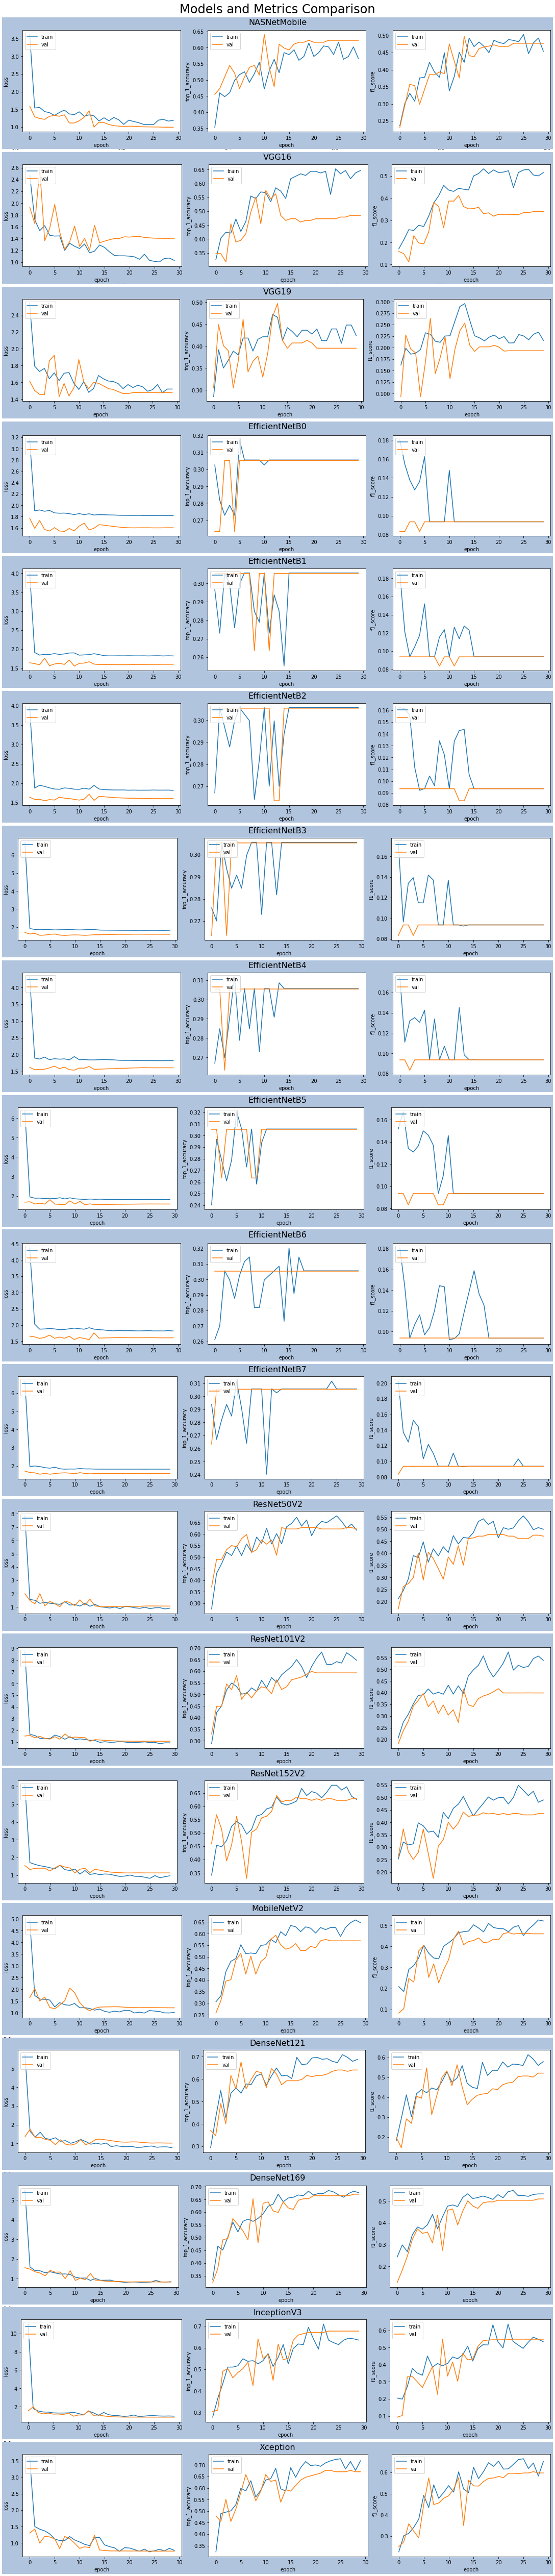

In [22]:
models_names = list(models.keys())

train_metrics = ['loss', 'top_1_accuracy', 'f1_score']
val_metrics = ['val_loss', 'val_top_1_accuracy', 'val_f1_score']

rows = len(models)
cols = 3

fig, ax = plt.subplots(nrows=rows, ncols=1, constrained_layout=True, figsize=(15, 70))
fig.suptitle('Models and Metrics Comparison', fontsize=24)

# create (models x 1) subfigs
subfigs = fig.subfigures(nrows=rows, ncols=1, wspace=0.2)

# axes are in a two-dimensional array, indexed by [row, col]
for row, subfig in enumerate(subfigs):
    # set subfig title
    subfig.suptitle(list(models.keys())[row], fontsize=16)
    subfig.set_facecolor('lightsteelblue')
    
    # create (1 x cols) subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        
        ax.plot(metric_history(models_names[row],train_metrics[col]))
        ax.plot(metric_history(models_names[row],val_metrics[col]))     
        ax.set_xlabel('epoch')
        ax.set_ylabel(train_metrics[col])
        ax.legend(['train', 'val'], loc='upper left')

### Compare Evaluation metrics

In [23]:
# Create list for each metric
eval_loss = []
eval_f1 = []
eval_acc = []

for [loss, f1, acc] in history_evaluation.values():
    eval_loss.append(loss)
    eval_f1.append(f1)
    eval_acc.append(acc)

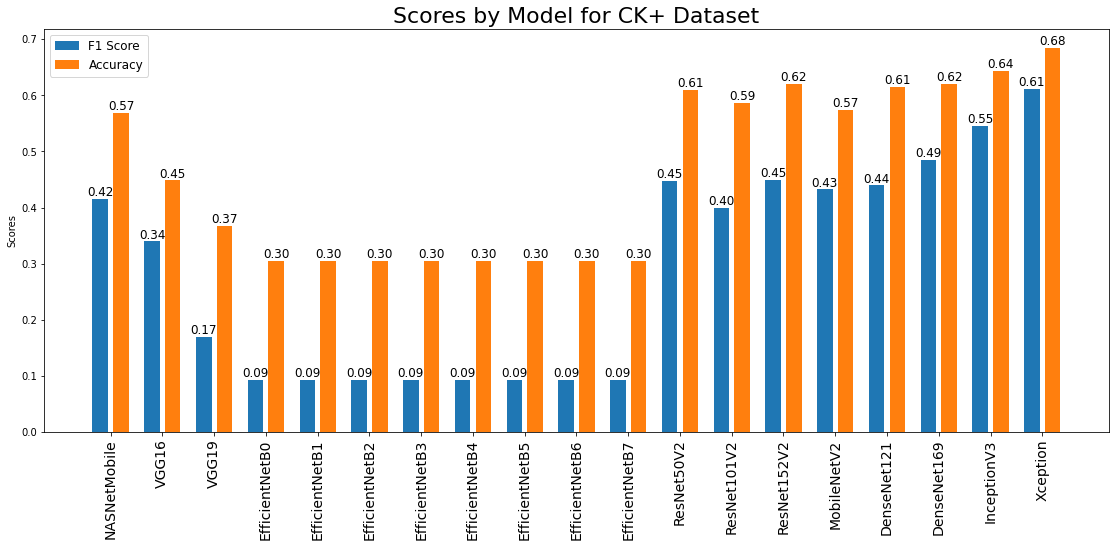

In [24]:
labels = models_names

x = np.arange(len(models_names))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 7))
rects1 = ax.bar(x - 0.2, eval_f1, width, label='F1 Score')
rects2 = ax.bar(x + 0.2, eval_acc, width, label='Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by Model for CK+ Dataset', fontsize=22)
ax.set_xticks(x, labels, rotation = 90, fontsize=14)
ax.legend(loc="upper left", fontsize=12)

ax.bar_label(rects1, fmt='%.2f', fontsize=12)
ax.bar_label(rects2, fmt='%.2f', fontsize=12)

fig.tight_layout(rect=(0,0,1.2,1.1))

plt.show()